# Hamiltonian simulation with Gray code encoding - QASM version

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()


import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *

## Time evolution of the deuteron system

Consider the $N=4$ deuteron system. We have two Hamiltonians obtained from the Gray code and one-hot encodings. Starting from an arbitrary quantum state, we can compute the state after the system evolves for time $t$ analytically as
$$
 |\psi(t)\rangle = e^{-iHt} |\psi(0)\rangle
$$

Let's suppose that $|\psi(0)\rangle$ is the uniform superposition of basis states for each system. For the Gray code, we have
$$
|\psi(0)\rangle = \frac{1}{2} \left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right)
$$
while for one-hot, we are concerned with a subset of the basis states of a 4-qubit system:
$$
|\psi(0)\rangle = \frac{1}{2} \left( |0001\rangle + |0010\rangle + |0100\rangle + |1000\rangle \right)
$$

In [2]:
# Perform unitary evolution 
def unitary_evolution(ham, t):
    return expm(-1j * ham * t)

# Basis states for the two systems
states_gc = ['00', '10', '11', '01']
states_oh = ['1000', '0100', '0010', '0001']

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Some simulation parameters; for better 'resolution', increase the number of timesteps 
timesteps = 1000
start_time = 0
end_time = 2
time_range = np.linspace(start_time, end_time, timesteps)

## QASM Simulation

In [3]:
# Arbitrary simulation time
T = 1

# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 100

backend = Aer.get_backend('qasm_simulator')

In [4]:
H_gc = DenseEncodingHamiltonian(N_states=4)

# Get the matrix in "qiskit order"
gc_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_gc.pauli_coeffs.items()])
uniform_superposition_gc = 0.5 * np.array([[1], [1], [1], [1]])

wavefunction = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc
true_probabilities = (wavefunction * np.conj(wavefunction)).flatten().real

true_results_gc = {'00' : true_probabilities[0],
                   '10' : true_probabilities[1],
                   '11' : true_probabilities[3],
                   '01' : true_probabilities[2]
                  }

In [5]:
exact_wavefunction_gc = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc

In [6]:
exact_wavefunction_gc * np.conj(exact_wavefunction_gc)

array([[0.64489016+0.j],
       [0.0502703 +0.j],
       [0.11822167+0.j],
       [0.18661787+0.j]])

In [7]:
true_results_gc

{'00': 0.644890158887242,
 '10': 0.050270303872851696,
 '11': 0.18661786653005275,
 '01': 0.11822167070985606}

This code loops over the different numbers of Trotter steps and performs the evolution by running the circuit using the statevector simulator.

In [8]:
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_gc.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

results_dict_gc = {x : np.zeros(max_trotter_steps) for x in states_gc}

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
    # Boilerplate code from tutorial
    q = QuantumRegister(H_gc.N_qubits)
    c = ClassicalRegister(H_gc.N_qubits)
    
    circuit = QuantumCircuit(q, c)
    
    circuit.h(q)
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
    circuit.measure(q, c)

    job = execute(circuit, backend, shots=10000)
    
    results = job.result().get_counts(circuit)

    for state in results_dict_gc.keys():
        if state[::-1] in results.keys():
            results_dict_gc[state[::-1]][n_trotter_steps-1] = results[state]/10000

100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


In [9]:
exact_wavefunction_gc

array([[-0.5742199 +0.56139261j],
       [ 0.09733696+0.20197975j],
       [ 0.17938808+0.29332846j],
       [ 0.39439354+0.17627138j]])

In [10]:
print(f"True state probabilities:")
for state in states_gc:
    print(f"{state}: {true_results_gc[state].real}")
print()
print(f"State probabilities at {max_trotter_steps} Trotter steps:")
for state in states_gc:
    print(f"{state}: {results_dict_gc[state][-1]}")

True state probabilities:
00: 0.644890158887242
10: 0.050270303872851696
11: 0.18661786653005275
01: 0.11822167070985606

State probabilities at 100 Trotter steps:
00: 0.658
10: 0.0394
11: 0.1779
01: 0.1247


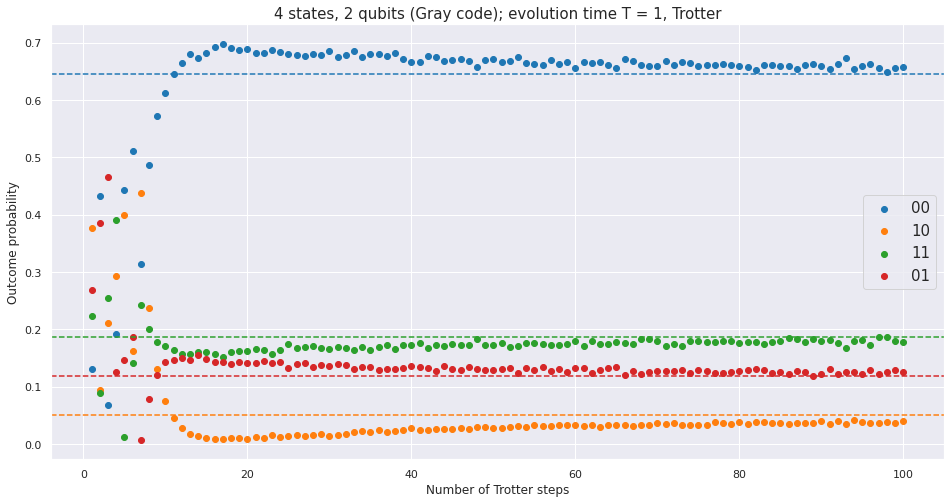

In [11]:
colour_idx = 0

for state in states_gc:
    plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_gc[state], label=state, color=colours[colour_idx])
    plt.axhline(y=true_results_gc[state], color=colours[colour_idx], linestyle='dashed')
    colour_idx += 1
plt.xlabel("Number of Trotter steps")
plt.ylabel("Outcome probability")
plt.legend(fontsize=15)
plt.title(f"4 states, 2 qubits (Gray code); evolution time T = {T}, Trotter", fontsize=15);
#plt.savefig("gc-trotter-probs.pdf")

Now we'll do the same thing for one-hot. We'll prepare the uniform superposition here by running the variational ansatz with the set of parameters that will produce it.

In [12]:
oh = SparseEncodingHamiltonian(N_states=4)
oh_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in oh.pauli_coeffs.items()])
uniform_oh = 0.5 * np.array([[0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0]]).reshape((16, 1))

exact_wavefunction_oh = unitary_evolution(oh_ham_rep, t=T) @ uniform_oh

true_probabilities = (exact_wavefunction_oh * np.conj(exact_wavefunction_oh)).flatten()

true_results_oh = {'1000' : true_probabilities[1],
                   '0100' : true_probabilities[2],
                   '0010' : true_probabilities[4],
                   '0001' : true_probabilities[8]}

In [13]:
H_oh = SparseEncodingHamiltonian(N_states=4, qiskit_order=True)
weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_oh.pauli_coeffs.items())]
my_pauli = WeightedPauliOperator(weighted_paulis)

results_dict_oh = {x : np.zeros(max_trotter_steps) for x in states_oh}

# To prepare the uniform superposition, run the sparse variational ansatz with the following parameters
θ_1 = 2 * np.pi / 3
θ_2 = 2 * np.arccos(1/np.sqrt(3)) 
θ_3 = 2 * np.arccos(1/(np.sqrt(3) * np.sin(θ_2 / 2)))
params = [θ_1, θ_2, θ_3]

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
    # Construct uniform superposition over spherical coordinates
    q = QuantumRegister(H_oh.N_qubits)
    c = ClassicalRegister(H_oh.N_qubits)
    
    circuit = QuantumCircuit(q, c)
    circuit.x(q[0])
    circuit.ry(θ_1, q[1])
    circuit.cx(q[1], q[0])
    circuit.cry(θ_2, q[1], q[2])
    circuit.cx(q[2], q[1])
    circuit.cry(θ_3, q[2], q[3])
    circuit.cx(q[3], q[2])
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
    circuit.measure(q, c)

    job = execute(circuit, backend, shots=10000)
    results = job.result().get_counts(circuit)
    
    for state in results_dict_oh.keys():
        if state[::-1] in results.keys():
            results_dict_oh[state[::-1]][n_trotter_steps-1] = results[state]/10000

100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


In [14]:
print(f"True state probabilities:")
for state in states_oh:
    print(f"{state}: {true_results_oh[state].real}")
print()
print(f"State probabilities at {max_trotter_steps} Trotter steps:")
for state in states_oh:
    print(f"{state}: {results_dict_oh[state][-1]}")

True state probabilities:
1000: 0.6448901588872414
0100: 0.05027030387285137
0010: 0.18661786653005197
0001: 0.11822167070985556

State probabilities at 100 Trotter steps:
1000: 0.6714
0100: 0.0407
0010: 0.1744
0001: 0.1127


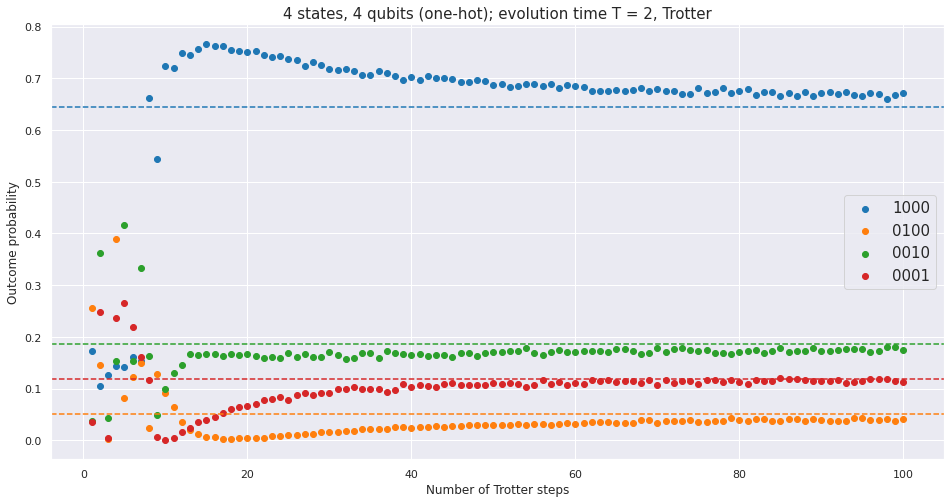

In [15]:
colour_idx = 0

for state in states_oh:
    plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_oh[state], label=state, color=colours[colour_idx])
    plt.axhline(y=true_results_oh[state], color=colours[colour_idx], linestyle='dashed')
    colour_idx += 1
    
plt.xlabel("Number of Trotter steps")
plt.ylabel("Outcome probability")
plt.legend(fontsize=15)
plt.title("4 states, 4 qubits (one-hot); evolution time T = 2, Trotter", fontsize=15);
#plt.savefig("oh-trotter-probs.pdf")

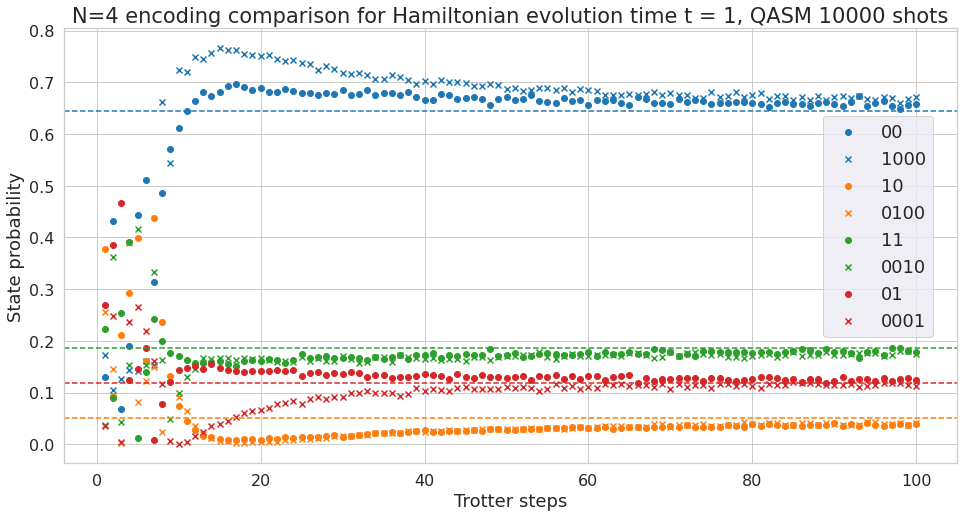

In [16]:
colour_idx = 0

with sns.axes_style("whitegrid"):
    for state_gc, state_oh in zip(states_gc, states_oh):
        plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_gc[state_gc], label=state_gc, color=colours[colour_idx])
        plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_oh[state_oh], label=state_oh, color=colours[colour_idx], marker='x')
        plt.axhline(y=true_results_oh[state_oh], color=colours[colour_idx], linestyle='dashed')
        colour_idx += 1
    
plt.xlabel("Trotter steps", fontsize=18)
plt.ylabel("State probability", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18, loc=(0.85, 0.29))
plt.title(f"N=4 encoding comparison for Hamiltonian evolution time t = {T}, QASM 10000 shots", fontsize=21);
#plt.savefig("paper-figures/trotter-probs-comparison.pdf")